In [1]:
from paretoKnapsackInfluence import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Import influence datasets
data_path_HEPT = '../../datasets/raw_data/influence/NetHEPT/hep.txt'
data_path_PHY = '../../datasets/raw_data/influence/NetPHY/phy.txt'

G_HEPT, node_costs_HEPT = import_influence_data(data_path_HEPT)
G_PHY, node_costs_PHY = import_influence_data(data_path_PHY)

2026-01-26 15:46:49,598 |INFO: Imported influence graph with 169 nodes and 793 edges
2026-01-26 15:46:51,226 |INFO: Imported influence graph with 151 nodes and 735 edges


In [2]:
def findApproximateParetoSolutionsKnapsackInfluence(G, node_costs, maxBudget, num_samples=35, num_runs=10, dataset_name=""):
    '''
    Run algorithms over multiple runs and plot mean +/- std (Influence vs Cost).
    Parameters:
    - G: Graph
    - node_costs: Node costs dict
    - maxBudget: Maximum knapsack budget
    - num_samples: Number of Monte Carlo samples per run
    - num_runs: Number of independent runs
    - dataset_name: Name of the dataset for plotting
    '''
    # Cost grid (same pattern as restaurants notebook)
    num_steps, min_cost = 10, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    # algo_names = ["PlainGreedy", "GreedyPlus", "TwoGuessPlainGreedy", "OneGuessGreedyPlus", "PrefixPareto-1Guess", "PrefixPareto-2Guess"]
    algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-Knapsack"]

    # containers across runs
    all_influences = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    pareto_costs_all = []

    for _ in range(num_runs):

        # Generate graph samples once to share across algorithms (per run)
        graph_samples = []
        for _ in range(num_samples):
            G_sample = nx.Graph()
            neighbors = defaultdict(set)
            connected_components = defaultdict()
            for u, v, data in G.edges(data=True):
                success = np.random.uniform(0, 1)
                if success < data['weight']:
                    G_sample.add_edge(u, v)
                    neighbors[u].add(v)
                    neighbors[v].add(u)
            for c in nx.connected_components(G_sample):
                for node in c:
                    connected_components[node] = c
            graph_samples.append((G_sample, neighbors, connected_components))

        run_influences = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        # Run algorithms over budgets
        for budgetVal in cost_arr:
            pareto = paretoKnapsackInfluence(G=G,
                                             node_costs=node_costs,
                                             budget=budgetVal,
                                             num_samples=num_samples,
                                             graph_samples=graph_samples)

            # Plain Greedy
            _, infl, cost, runTime = pareto.plainGreedy()
            run_influences['PlainGreedy'].append(infl)
            run_runtimes['PlainGreedy'].append(runTime)

            # Two Guess Plain Greedy
            _, infl, cost, runTime = pareto.twoGuessPlainGreedy()
            run_influences['PlainGreedy-2Guess'].append(infl)
            run_runtimes['PlainGreedy-2Guess'].append(runTime)

            # One Guess Greedy Plus
            _, infl, cost, runTime = pareto.oneGuessGreedyPlus()
            run_influences['GreedyPlus-1Guess'].append(infl)
            run_runtimes['GreedyPlus-1Guess'].append(runTime)

        # Pareto Greedy (computed once per run at full budget)
        pareto_full = paretoKnapsackInfluence(G=G,
                                              node_costs=node_costs,
                                              budget=maxBudget,
                                              num_samples=num_samples,
                                              graph_samples=graph_samples)

        pg1_costs, pg1_influences, _, pg1_time = pareto_full.prefixParetoGreedy_2Guess()
        # pg2_costs, pg2_influences, _, pg2_time = pareto_full.prefixParetoGreedy_2Guess()

        # Align pareto curves to cost_arr by interpolation
        def align_to_cost_arr(costs, infls):
            if len(costs) == 0:
                return np.zeros_like(cost_arr, dtype=float)
            costs = np.array(costs)
            infls = np.array(infls)
            return np.interp(cost_arr, costs, infls, left=infls[0], right=infls[-1])

        run_influences['ParetoGreedy-Knapsack'] = list(align_to_cost_arr(pg1_costs, pg1_influences))
        # run_influences['ParetoGreedy-2'] = list(align_to_cost_arr(pg2_costs, pg2_influences))
        run_runtimes['ParetoGreedy-Knapsack'].append(pg1_time)
        # run_runtimes['ParetoGreedy-2'].append(pg2_time)
        pareto_costs_all.extend(pg1_costs)

        # store per-run arrays and total runtimes
        for alg in algo_names:
            arr = np.array(run_influences[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(cost_arr, dtype=float)
            all_influences[alg].append(arr)
            total_runtime = float(np.nansum(np.array(run_runtimes.get(alg, []), dtype=float))) if len(run_runtimes.get(alg, [])) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    # compute mean and std across runs for each algorithm
    mean_influences = {}
    std_influences = {}
    for alg in algo_names:
        stacked = np.vstack(all_influences[alg])  # shape (num_runs, len(cost_arr))
        mean_influences[alg] = np.mean(stacked, axis=0)
        std_influences[alg] = np.std(stacked, axis=0) * 0.5

    # Plot mean influence with shaded std band (consistent with restaurants formatting)
    # colors = cm.viridis(np.linspace(0.05, 0.85, len(algo_names)))
    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3,1,1,1))]
    markers = ['o', 's', '^', 'v', 'D']

    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_influences[alg]
        std = std_influences[alg]
        is_pareto = alg in {"ParetoGreedy-Knapsack", "ParetoGreedy-2"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'

        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy-2":
            marker = "x"
            zorder = 5
        elif alg == "ParetoGreedy-Knapsack":
            marker = "D"
            zorder = 4

        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        if is_pareto and len(pareto_costs_all) > 0:
            ax.plot(cost_arr, mean,
                    label="_nolegend_",
                    color=color,
                    linestyle=line_style,
                    linewidth=1.8,
                    zorder=zorder)
            pareto_costs_unique = np.unique(np.array(pareto_costs_all, dtype=float))
            pareto_costs_unique = pareto_costs_unique[(pareto_costs_unique >= cost_arr.min()) & (pareto_costs_unique <= cost_arr.max())]
            pareto_mean_vals = np.interp(pareto_costs_unique, cost_arr, mean)
            ax.scatter(pareto_costs_unique, pareto_mean_vals,
                       label=label,
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
        else:
            ax.plot(cost_arr, mean,
                    label=label,
                    color=color,
                    linestyle=line_style,
                    marker=marker,
                    markersize=marker_size,
                    markeredgewidth=1.1,
                    markeredgecolor='k',
                    linewidth=1.8,
                    zorder=zorder)
        ax.fill_between(cost_arr,
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Cost ($c_\ell$)', fontsize=24)
    ax.set_ylabel(r'Mean influence ($\bar{f}$)', fontsize=24)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=20)

    # Legend inside bottom right
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.98, 0.02), fontsize=18, frameon=True)

    # # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))

    return mean_influences, cost_arr, all_runtimes


### NetHEPT Experiments

In [3]:
# Parameters
maxBudget = 15
num_samples = 5
num_runs = 3

2026-01-26 15:46:51,349 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=1.0
2026-01-26 15:46:51,371 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=2.5555555555555554
2026-01-26 15:46:51,433 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=4.111111111111111
2026-01-26 15:46:51,663 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=5.666666666666667
2026-01-26 15:46:52,148 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=7.222222222222222
2026-01-26 15:46:53,504 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=8.777777777777779
2026-01-26 15:46:55,495 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=10.333333333333334
2026-01-26 15:46:58,903 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=11.88888888888889
2026

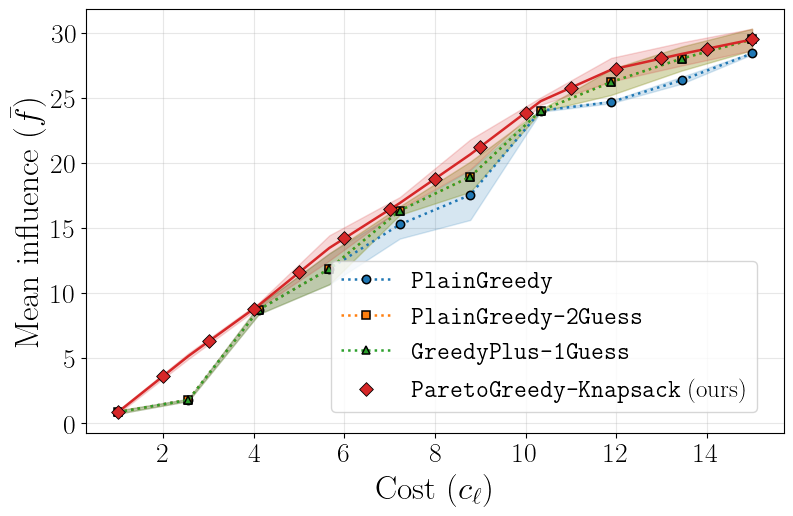

2026-01-26 15:48:35,376 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.043 ± 0.004
  - PlainGreedy-2Guess: 23.622 ± 0.968
  - GreedyPlus-1Guess: 3.472 ± 0.094
  - ParetoGreedy-Knapsack: 7.241 ± 0.166


In [4]:
# Run for NetHEPT
influences_HEPT, costs_HEPT, runtimes_HEPT = findApproximateParetoSolutionsKnapsackInfluence(
    G_HEPT,
    node_costs_HEPT,
    maxBudget,
    num_samples=num_samples,
    num_runs=num_runs,
    dataset_name="NetHEPT"
)

### NetPHY Experiments

2026-01-26 15:48:35,410 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=1.0
2026-01-26 15:48:35,423 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=2.5555555555555554
2026-01-26 15:48:35,438 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=4.111111111111111
2026-01-26 15:48:35,564 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=5.666666666666667
2026-01-26 15:48:35,838 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=7.222222222222222
2026-01-26 15:48:36,926 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=8.777777777777779
2026-01-26 15:48:38,849 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=10.333333333333334
2026-01-26 15:48:42,849 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=11.88888888888889
2026

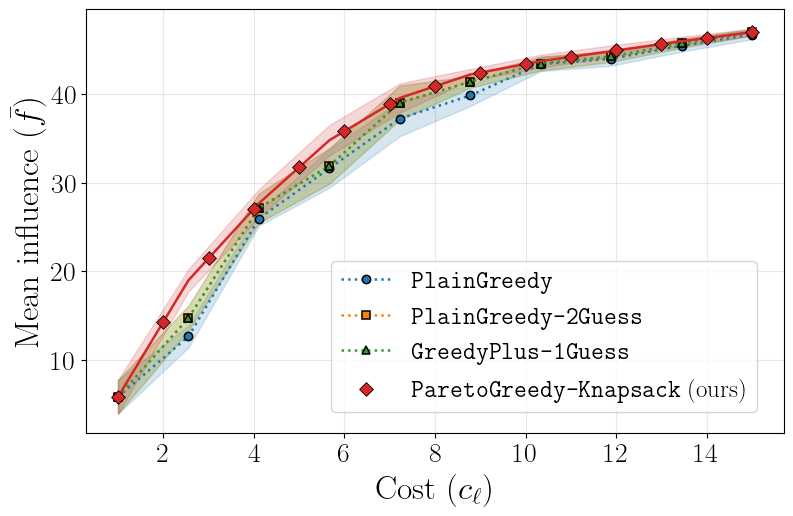

2026-01-26 15:50:44,950 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.046 ± 0.001
  - PlainGreedy-2Guess: 29.124 ± 2.872
  - GreedyPlus-1Guess: 4.395 ± 0.615
  - ParetoGreedy-Knapsack: 9.468 ± 0.972


In [5]:
# Run for NetPHY
influences_PHY, costs_PHY, runtimes_PHY = findApproximateParetoSolutionsKnapsackInfluence(
    G_PHY,
    node_costs_PHY,
    maxBudget,
    num_samples=num_samples,
    num_runs=num_runs,
    dataset_name="NetPHY"
)